## 1. Import Libraries

In [74]:
# pip install shap
# pip install lightgbm
# pip install xgboost
# pip install scikit-plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
warnings.filterwarnings('ignore')

## 2. Data Loading and Raw Exploratory Data Analysis

In [35]:
with open('census-bureau.columns', 'r') as f:
    column_names = [line.strip() for line in f.readlines() if line.strip()]

df = pd.read_csv('census-bureau.data', names=column_names, skipinitialspace=True)
df.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [36]:
column_names

['age',
 'class of worker',
 'detailed industry recode',
 'detailed occupation recode',
 'education',
 'wage per hour',
 'enroll in edu inst last wk',
 'marital stat',
 'major industry code',
 'major occupation code',
 'race',
 'hispanic origin',
 'sex',
 'member of a labor union',
 'reason for unemployment',
 'full or part time employment stat',
 'capital gains',
 'capital losses',
 'dividends from stocks',
 'tax filer stat',
 'region of previous residence',
 'state of previous residence',
 'detailed household and family stat',
 'detailed household summary in household',
 'weight',
 'migration code-change in msa',
 'migration code-change in reg',
 'migration code-move within reg',
 'live in this house 1 year ago',
 'migration prev res in sunbelt',
 'num persons worked for employer',
 'family members under 18',
 'country of birth father',
 'country of birth mother',
 'country of birth self',
 'citizenship',
 'own business or self employed',
 "fill inc questionnaire for veteran's admin"

### 2.1 Missing Value Analysis

In [37]:
df_missing = df.replace('?', np.nan)
missing_counts = df_missing.isnull().sum()
missing_percentage = (missing_counts / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_percentage
})

missing_report = missing_summary[missing_summary['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)

print(missing_report)

                                Missing Count  Percentage
migration code-change in msa            99696   49.967172
migration code-change in reg            99696   49.967172
migration code-move within reg          99696   49.967172
migration prev res in sunbelt           99696   49.967172
country of birth father                  6713    3.364524
country of birth mother                  6119    3.066814
country of birth self                    3393    1.700556
hispanic origin                           874    0.438045
state of previous residence               708    0.354846


In [38]:
# Check if missing data is random
all_missing_cols = missing_report.index.tolist()

print(f"Auditing all missing columns: {all_missing_cols}")

# 2. Target and Age distribution for each missing column
audit_results = []

for col in all_missing_cols:
    # Create temporary indicator: 1 if missing, 0 if present
    is_missing = df_missing[col].isnull()
    
    # Check Target (>50k rate)
    target_dist = pd.crosstab(is_missing, df['label'], normalize='index') * 100
    high_income_gap = target_dist.iloc[1]['50000+.'] - target_dist.iloc[0]['50000+.']
    
    # Check Age Mean
    age_missing = df[is_missing]['age'].mean()
    age_present = df[~is_missing]['age'].mean()
    age_gap = age_missing - age_present
    
    audit_results.append({
        'Column': col,
        'Missing %': missing_report.loc[col, 'Percentage'],
        'Income Gap (pp)': round(high_income_gap, 2),
        'Age Gap (years)': round(age_gap, 2)
    })

# Display Audit Table
audit_df = pd.DataFrame(audit_results)
print("\n--- Missingness Audit Summary ---")
print(audit_df)

Auditing all missing columns: ['migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'migration prev res in sunbelt', 'country of birth father', 'country of birth mother', 'country of birth self', 'hispanic origin', 'state of previous residence']

--- Missingness Audit Summary ---
                           Column  Missing %  Income Gap (pp)  Age Gap (years)
0    migration code-change in msa  49.967172             0.71             0.20
1    migration code-change in reg  49.967172             0.71             0.20
2  migration code-move within reg  49.967172             0.71             0.20
3   migration prev res in sunbelt  49.967172             0.71             0.20
4         country of birth father   3.364524             2.04            11.30
5         country of birth mother   3.066814             1.51            10.49
6           country of birth self   1.700556             2.59             5.57
7                 hispanic origin   0.4380

### 2.2 Skewness Assessment

age: Skewness = 0.37


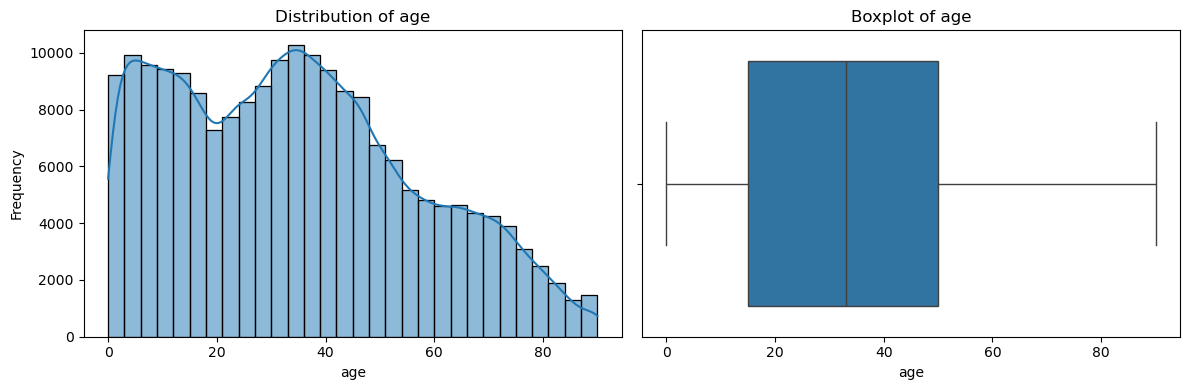

wage per hour: Skewness = 8.94


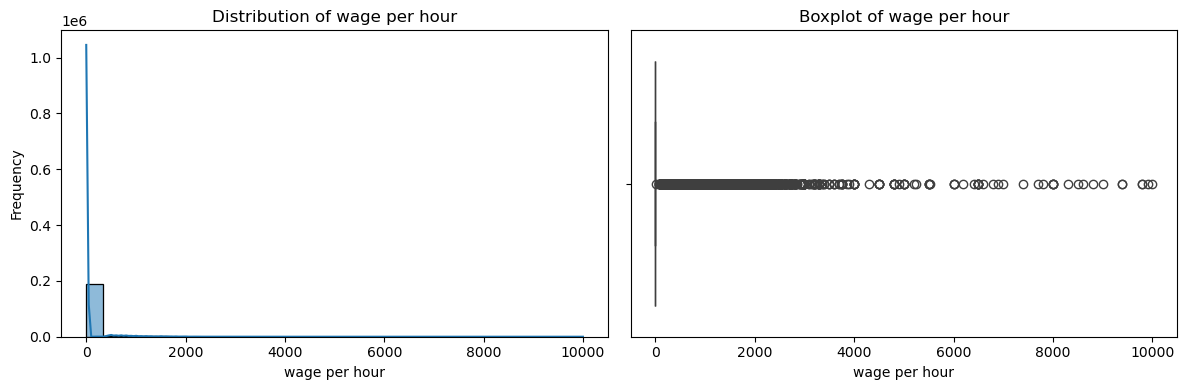

capital gains: Skewness = 18.99


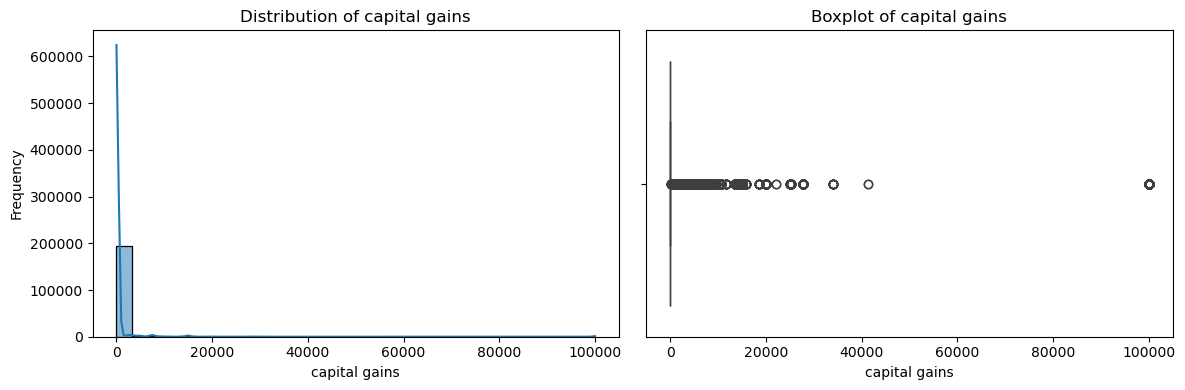

capital losses: Skewness = 7.63


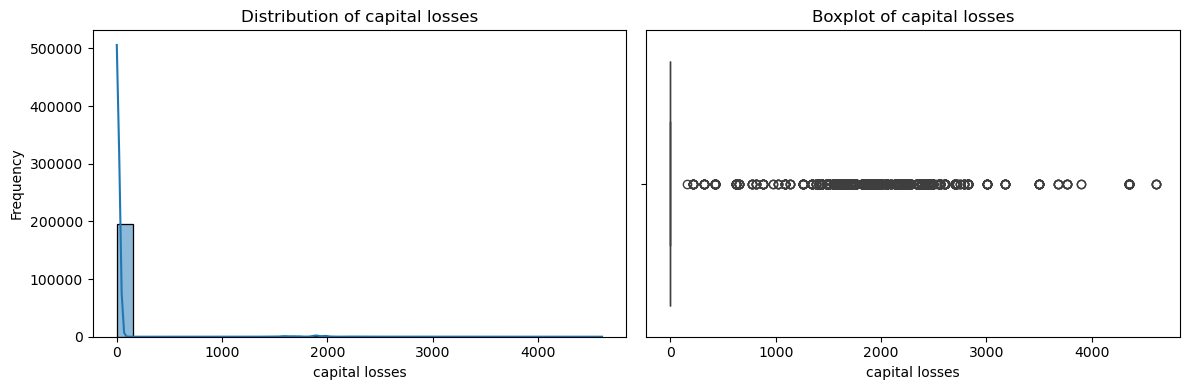

dividends from stocks: Skewness = 27.79


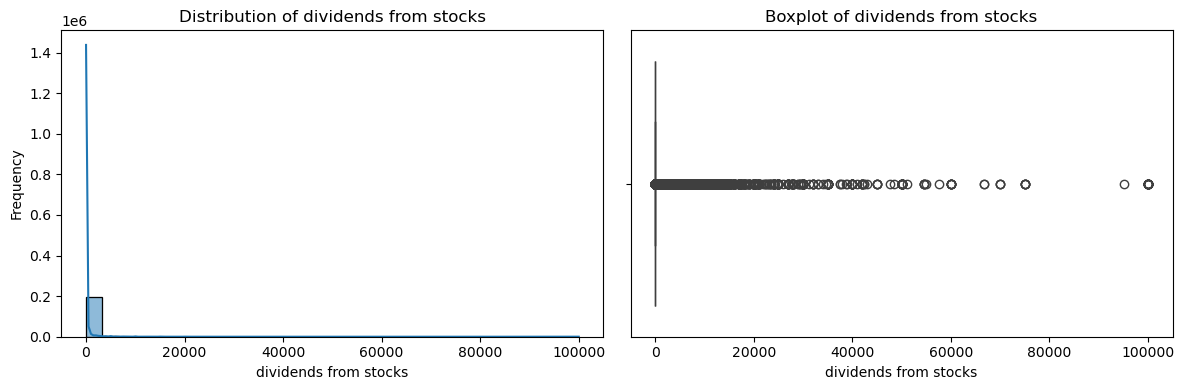

num persons worked for employer: Skewness = 0.75


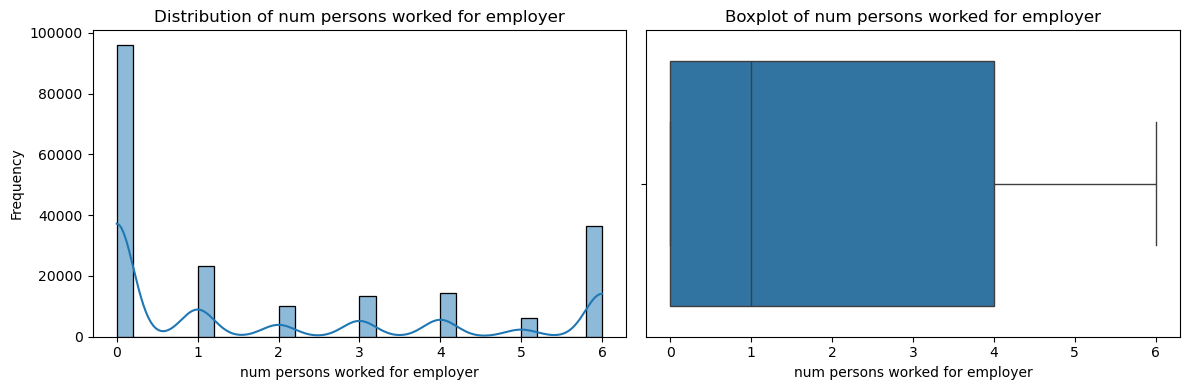

weeks worked in year: Skewness = 0.21


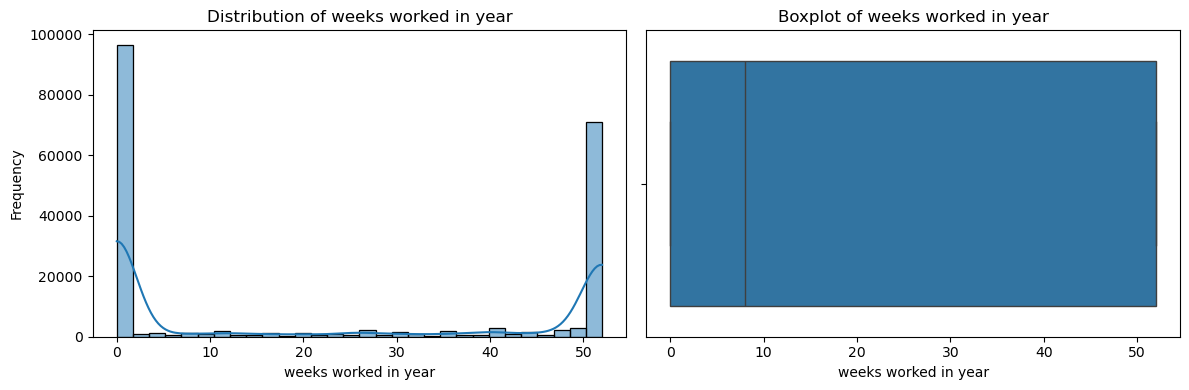

In [42]:
from scipy.stats import skew

# Define numerical columns based on the dataset structure
num_cols = [
    'age', 'wage per hour', 'capital gains', 'capital losses', 
    'dividends from stocks', 'num persons worked for employer', 'weeks worked in year'
]

for col in num_cols:
    current_skew = df[col].skew()
    print(f"{col}: Skewness = {current_skew:.2f}")
    
    plt.figure(figsize=(12, 4))
    
    # 1. Histogram with Kernel Density Estimate (KDE)
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    # 2. Boxplot to identify outliers and spread
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    
    plt.tight_layout()
    plt.savefig(f'dist_{col}.png')
    plt.show()

Extreme Skewness: capital gains (18.99), dividends from stocks (27.79), and wage per hour (8.94) are heavily skewed. These variables have a "long tail" where most people have 0, but a few have very high values.

Moderate Skewness: capital losses (7.63) is also skewed but to a lesser degree than gains.

Normal-ish Distribution: age (0.37) and weeks worked in year (0.21) are relatively well-distributed, though weeks worked has a bimodal peak (0 weeks and 52 weeks).

### 2.3 Target Variable Distribution Analysis

In [39]:
# Check distribution of the target label
target_counts = df['label'].value_counts()
target_pct = df['label'].value_counts(normalize=True) * 100

print("Target Distribution:")
print(target_counts)
print("\nPercentage:")
print(target_pct)

Target Distribution:
label
- 50000.    187141
50000+.      12382
Name: count, dtype: int64

Percentage:
label
- 50000.    93.794199
50000+.      6.205801
Name: proportion, dtype: float64


#### Extreme Class Imbalance: About 93.8% of the population earns less than $50k, while only 6.2% earns more. Need to use F1-score or Precision-Recall

## 3. Data Preprocessing

### 3.1 Handling Missing Values

In [40]:
# Based on the audit summary,
# 1. Migration data: Random enough to use 'Unknown'
migration_cols = [
    'migration code-change in msa', 'migration code-change in reg',
    'migration code-move within reg', 'migration prev res in sunbelt'
]
df[migration_cols] = df_missing[migration_cols].fillna('Unknown')

# 2. Country of Birth: Significant Age Gap detected (~11 years)
# Since they represent a distinct older demographic, using 'Unknown' is better than imputing
birth_cols = ['country of birth father', 'country of birth mother', 'country of birth self']
df[birth_cols] = df_missing[birth_cols].fillna('Unknown')

# 3. Geo/Identity: Minimal gaps or very low missing %, use 'Unknown' for consistency
# This allows the model to decide if "missingness" itself is a predictor
identity_cols = ['hispanic origin', 'state of previous residence']
df[identity_cols] = df_missing[identity_cols].fillna('Unknown')

### 3.2 Unique Value Assessment for One-Hot Encoding

In [41]:
# Check unique values for categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    print(f"{col}: {df[col].nunique()}")

class of worker: 9
education: 17
enroll in edu inst last wk: 3
marital stat: 7
major industry code: 24
major occupation code: 15
race: 5
hispanic origin: 10
sex: 2
member of a labor union: 3
reason for unemployment: 6
full or part time employment stat: 8
tax filer stat: 6
region of previous residence: 6
state of previous residence: 51
detailed household and family stat: 38
detailed household summary in household: 8
migration code-change in msa: 10
migration code-change in reg: 9
migration code-move within reg: 10
live in this house 1 year ago: 3
migration prev res in sunbelt: 4
family members under 18: 5
country of birth father: 43
country of birth mother: 43
country of birth self: 43
citizenship: 5
fill inc questionnaire for veteran's admin: 3
label: 2


### 3.3 Log Transformation for Skewed Features

In [43]:
# Numerical Transformation: Log transformation for extreme skewness
# Log1p handles the high volume of zeros by calculating log(1 + x)
skewed_cols = ['capital gains', 'capital losses', 'dividends from stocks', 'wage per hour']
for col in skewed_cols:
    df[col] = np.log1p(df[col])

### 3.4 Feature & Label Encoding

In [44]:
# Categorical Encoding: Direct Label Encoding
# We keep all categories to preserve signal from high-income rare groups
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ensure the binary target is created
df['income_target'] = df['label'].apply(lambda x: 1 if '50000+.' in str(x) else 0)

# Identify categorical features (excluding original label and new target)
cat_features = df.select_dtypes(include=['object']).columns.drop('label')

le = LabelEncoder()
for col in cat_features:
    df[col] = le.fit_transform(df[col].astype(str))

## 4. Post-Processing EDA

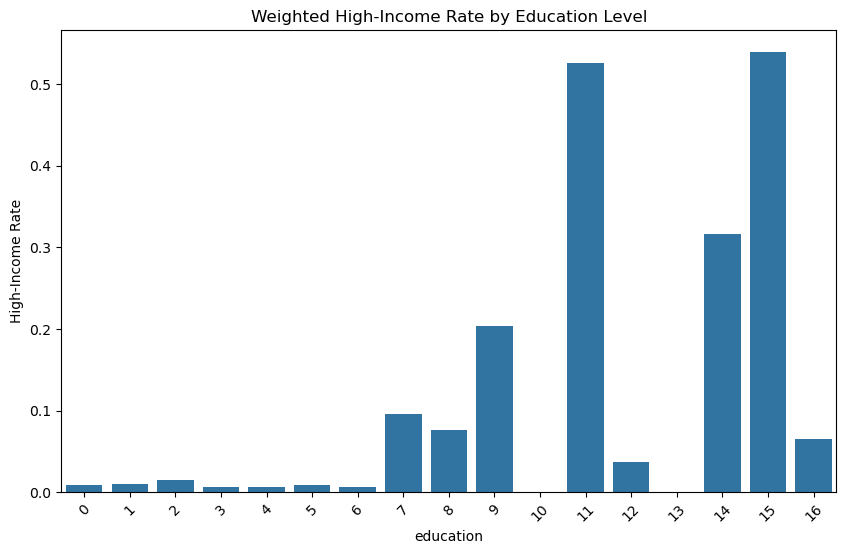

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Weighted high-income rate by education
edu_income = (
    df.groupby('education')
      .apply(lambda x: np.average(x['income_target'], weights=x['weight']))
      .reset_index(name='weighted_high_income_rate')
)

plt.figure(figsize=(10,6))
sns.barplot(data=edu_income, x='education', y='weighted_high_income_rate')
plt.title('Weighted High-Income Rate by Education Level')
plt.ylabel('High-Income Rate')
plt.xticks(rotation=45)
plt.show()

Education level demonstrates a strong monotonic relationship with high-income probability. Individuals in the highest education tiers exhibit income rates above 50%, compared to below 5% in the lowest tiers.

In [90]:
edu_income

,education,weighted_high_income_rate
0,0,0.008342
1,1,0.010311
2,2,0.014814
3,3,0.006410
4,4,0.006461
5,5,0.008839
6,6,0.005961
7,7,0.096324
8,8,0.075936
9,9,0.203474


In [81]:
weeks_summary = (
    df.groupby('income_target')
      .apply(lambda x: np.average(x['weeks worked in year'], weights=x['weight']))
      .reset_index(name='weighted_avg_weeks_worked')
)

print(weeks_summary)

   income_target  weighted_avg_weeks_worked
0              0                  21.900271
1              1                  48.163953


High-income individuals worked on average 48 weeks per year, compared to 22 weeks for low-income individuals, suggesting employment intensity as a key driver of income classification.

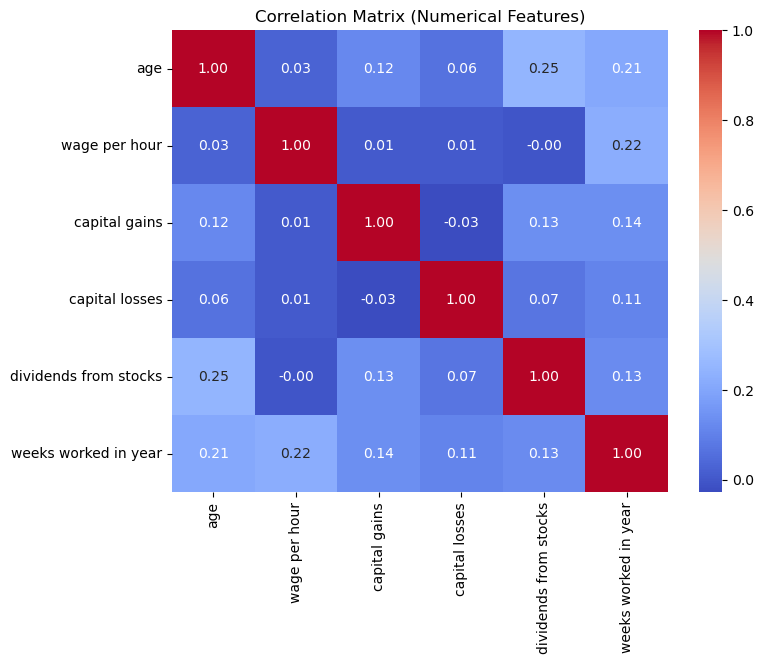

In [83]:
num_cols = [
    'age', 
    'wage per hour', 
    'capital gains', 
    'capital losses', 
    'dividends from stocks', 
    'weeks worked in year'
]

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

No severe multicollinearity was detected among key numerical features, supporting model stability and interpretability.

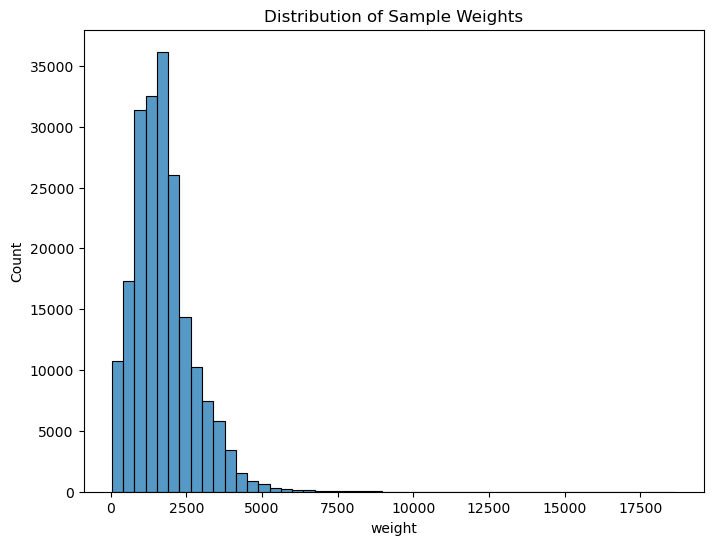

In [89]:
plt.figure(figsize=(8,6))
sns.histplot(df['weight'], bins=50)
plt.title('Distribution of Sample Weights')
plt.show()

In [85]:
# Unweighted income rate
unweighted_rate = df['income_target'].mean()

# Weighted income rate
weighted_rate = np.average(df['income_target'], weights=df['weight'])

print("Unweighted High-Income Rate:", round(unweighted_rate, 4))
print("Weighted High-Income Rate:", round(weighted_rate, 4))

Unweighted High-Income Rate: 0.0621
Weighted High-Income Rate: 0.0641


The weighted income rate differs from the unweighted rate, validating the use of population weights in modeling and evaluation.

## 4. Classification Model Development

### 4.1 Train-Test Split

In [45]:
# Data Splitting: Stratified to preserve class imbalance
X = df.drop(['label', 'income_target'], axis=1)
y = df['income_target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 4.2 Model Comparison

In [49]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(scale_pos_weight=9, 
                             use_label_encoder=False, 
                             eval_metric='aucpr',
                             random_state=42, 
                             n_jobs=-1)
}

scoring = ['recall', 'precision', 'f1', 'roc_auc']
results = {}

print("--- Comparing All Models (including XGBoost) ---")
for name, model in models.items():
    fit_params = {'sample_weight': X_train['weight']}
    
    cv_results = cross_validate(model, X_train.drop('weight', axis=1), y_train, 
                                cv=3, scoring=scoring, n_jobs=-1, params=fit_params)
    
    results[name] = {
        'Recall': cv_results['test_recall'].mean(),
        'Precision': cv_results['test_precision'].mean(),
        'F1-Score': cv_results['test_f1'].mean(),
        'ROC-AUC': cv_results['test_roc_auc'].mean()
    }
    print(f"{name} Evaluation Complete.")

comparison_df = pd.DataFrame(results).T
display(comparison_df.sort_values(by='Recall', ascending=False).style.highlight_max(axis=0, color='lightgreen'))

--- Comparing All Models (including XGBoost) ---


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Logistic Regression Evaluation Complete.
Random Forest Evaluation Complete.
LightGBM Evaluation Complete.


/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [20:35:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [20:35:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [20:35:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Evaluation Complete.


,Recall,Precision,F1-Score,ROC-AUC
LightGBM,0.877246,0.318861,0.467713,0.950935
Logistic Regression,0.872905,0.244918,0.382512,0.925974
XGBoost,0.783263,0.402471,0.531711,0.942210
Random Forest,0.361296,0.727397,0.482782,0.934624


### 4.3 Hyperparameter Tuning

In [52]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'scale_pos_weight': [1, 3, 5, 7, 9]
}

random_search = RandomizedSearchCV(
    estimator=final_xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)


random_search.fit(
    X_train.drop('weight', axis=1), 
    y_train, 
    sample_weight=X_train['weight']
)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best CV F1-Score: {random_search.best_score_:.4f}")


best_xgb = random_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test.drop('weight', axis=1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [20:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [20:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [20:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [20:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best Parameters: {'subsample': 0.9, 'scale_pos_weight': 3, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}
Best CV F1-Score: 0.6074


In [53]:
y_scores = best_xgb.predict_proba(
    X_test.drop('weight', axis=1)
)[:, 1]

In [54]:
from sklearn.metrics import f1_score
import numpy as np

best_f1 = 0
best_t = 0

for t in np.linspace(0.1, 0.9, 200):
    y_pred = (y_scores > t).astype(int)
    f1 = f1_score(y_test, y_pred, sample_weight=X_test['weight'])
    
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best threshold:", best_t)
print("Best F1:", best_f1)

Best threshold: 0.5422110552763819
Best F1: 0.6284968816086216


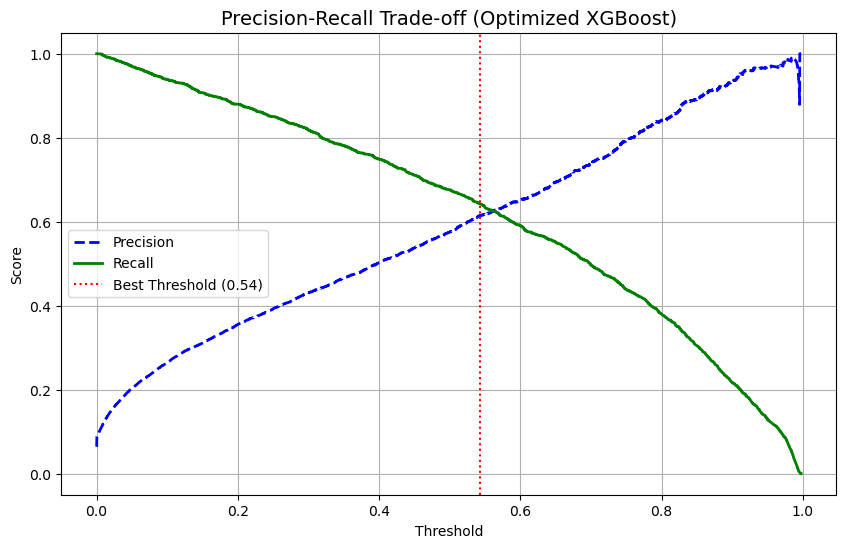

In [55]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores, sample_weight=X_test['weight'])

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

plt.axvline(x=best_t, color='red', linestyle=':', label=f'Best Threshold ({best_t:.2f})')

plt.title('Precision-Recall Trade-off (Optimized XGBoost)', fontsize=14)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

### 4.4 Final Model Selection

In [56]:
# Final Model Validation
y_pred_final = (y_scores > best_t).astype(int)

print("XGBoost Final Validation:")
print(classification_report(y_test, y_pred_final, sample_weight=X_test['weight']))

XGBoost Final Validation:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97 64953101.679999925
           1       0.61      0.64      0.63 4483480.5600000145

    accuracy                           0.95 69436582.23999994
   macro avg       0.79      0.81      0.80 69436582.23999994
weighted avg       0.95      0.95      0.95 69436582.23999994



## 5. Model Evaluation and Explainability

### 5.1 Line Chart

<Figure size 800x600 with 0 Axes>

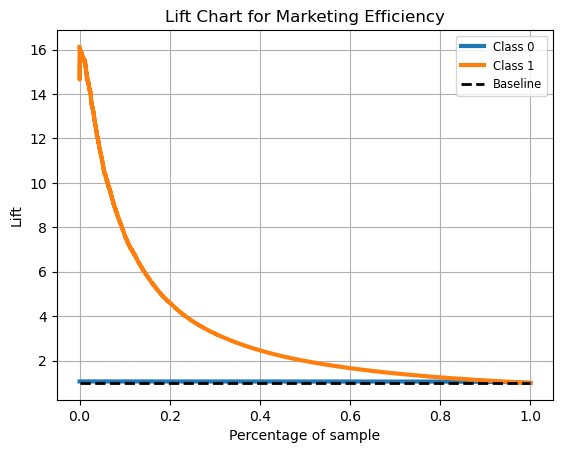

In [64]:
import numpy as np
import scipy
scipy.interp = np.interp

import scikitplot as skplt
y_probas = np.vstack([(1 - y_scores), y_scores]).T

plt.figure(figsize=(8, 6))
skplt.metrics.plot_lift_curve(y_test, y_probas)

plt.legend(loc='upper right', fontsize='small') 

plt.title('Lift Chart for Marketing Efficiency')
plt.grid(True)
plt.show()

### 5.2 XG Boost Feature Importance

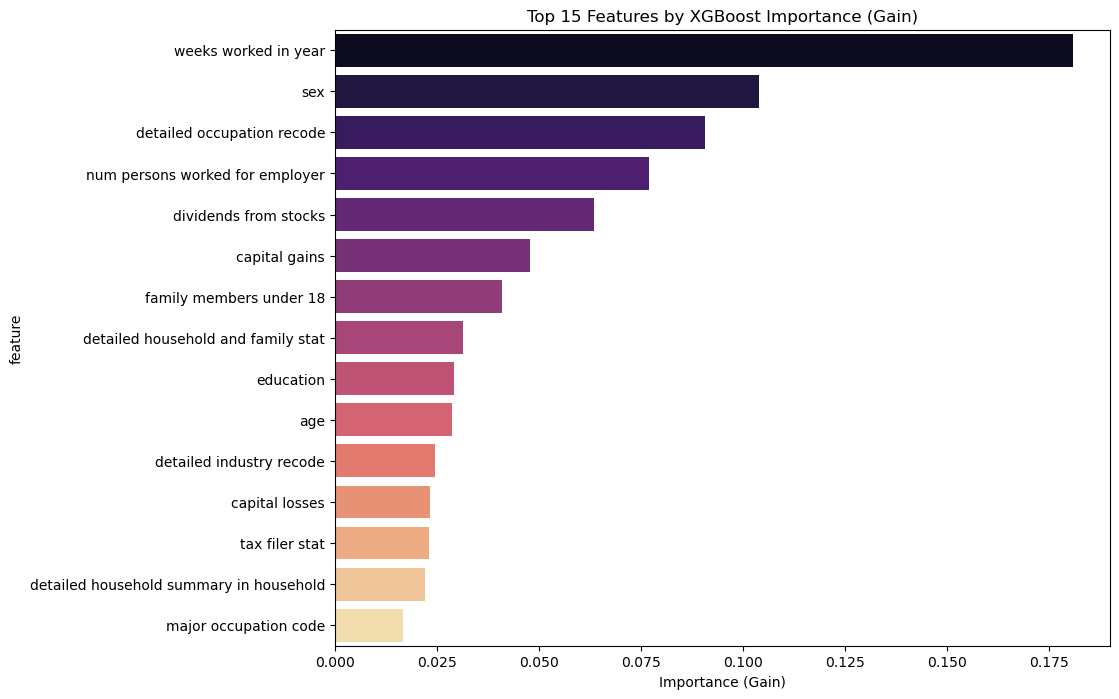

In [65]:
importances = best_xgb.feature_importances_
feature_names = X_train.drop('weight', axis=1).columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='magma')
plt.title('Top 15 Features by XGBoost Importance (Gain)')
plt.xlabel('Importance (Gain)')
plt.show()

### 5.3 SHAP Analysis

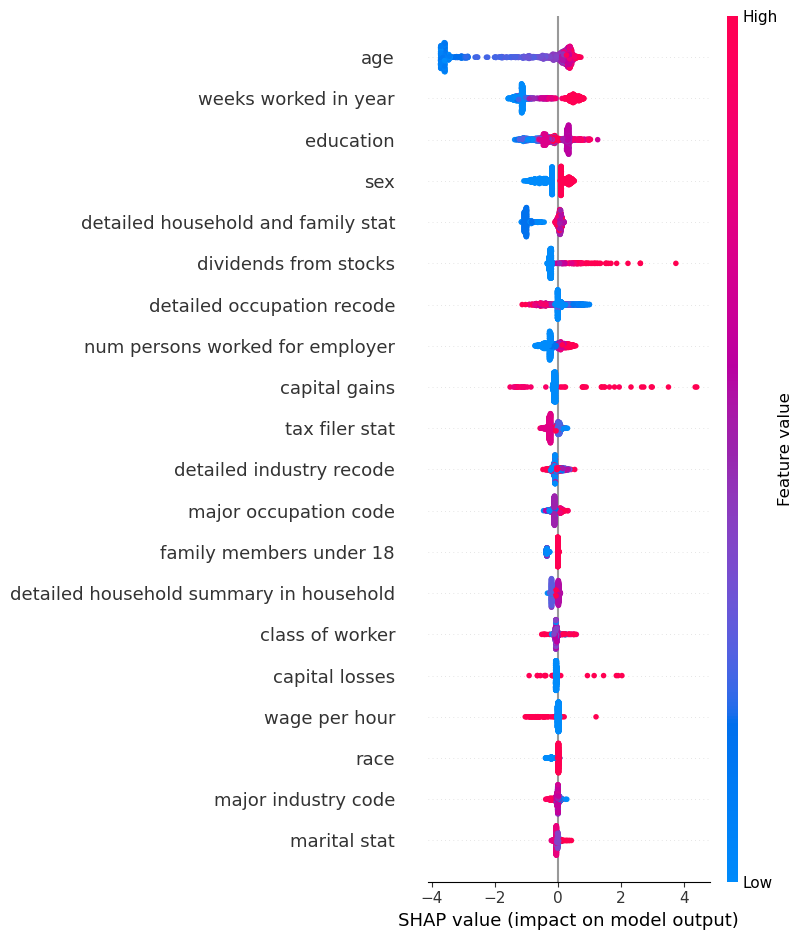

In [66]:
import shap

explainer = shap.TreeExplainer(best_xgb)

X_test_sample = X_test.drop('weight', axis=1).sample(1000, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="dot")

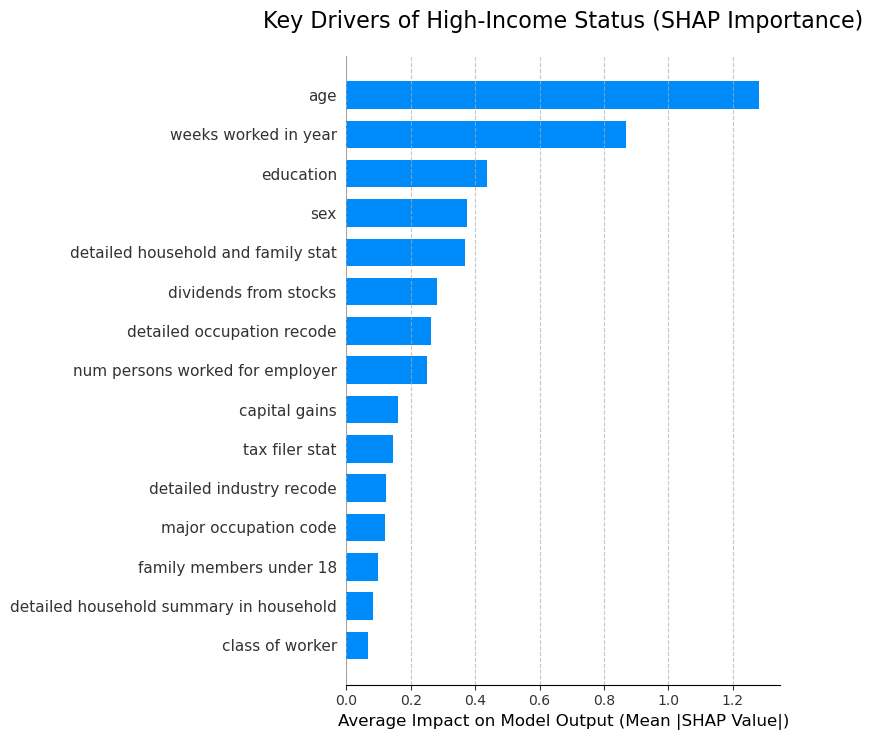

In [67]:
import shap
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", max_display=15, show=False)

plt.title("Key Drivers of High-Income Status (SHAP Importance)", fontsize=16, pad=20)
plt.xlabel("Average Impact on Model Output (Mean |SHAP Value|)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

## 6. Final Model Output and Data Export

In [73]:
train_cols = X_train.drop('weight', axis=1).columns.tolist()
features_for_prediction = df[train_cols]

probs = best_xgb.predict_proba(features_for_prediction)[:, 1]

final_df = df.copy()
final_df['income_probability'] = probs
final_df['predicted_income'] = (probs > best_t).astype(int)

final_df.to_csv('jpmc_income_analysis_results.csv', index=False)
print("Data saved successfully")

Data saved successfully with guaranteed column alignment!
